In [ ]:
!pip install mediapipe

In [151]:
import cv2
import mediapipe as mp
import numpy as np
import math

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

data = {
    "NOSE":[],
    "LEFT_EYE_INNER":[],
    "LEFT_EYE":[],
    "LEFT_EYE_OUTER":[],
    "RIGHT_EYE_INNER":[],
    "RIGHT_EYE":[],
    "RIGHT_EYE_OUTER":[],
    "LEFT_EAR":[],
    "RIGHT_EAR":[],
    "MOUTH_LEFT":[],
    "MOUTH_RIGHT":[],
    "LEFT_SHOULDER":[],
    "RIGHT_SHOULDER":[],
    "LEFT_ELBOW":[],
    "RIGHT_ELBOW":[],
    "LEFT_WRIST":[],
    "RIGHT_WRIST":[],
    "LEFT_PINKY":[],
    "RIGHT_PINKY":[],
    "LEFT_INDEX":[],
    "RIGHT_INDEX":[],
    "LEFT_THUMB":[],
    "RIGHT_THUMB":[],
    "LEFT_HIP":[],
    "RIGHT_HIP":[],
    "LEFT_KNEE":[],
    "RIGHT_KNEE":[],
    "LEFT_ANKLE":[],
    "RIGHT_ANKLE":[],
    "LEFT_HEEL":[],
    "RIGHT_HEEL":[],
    "LEFT_FOOT_INDEX":[],
    "RIGHT_FOOT_INDEX":[]
}

In [152]:

#For video
path = '/content/wrong.mp4'
cap = cv2.VideoCapture(path)
# Obtiene la velocidad de fotogramas (fps)
fps = cap.get(cv2.CAP_PROP_FPS)
if not cap.isOpened():
  print('Failed opening video')
else:
  empty = []
  images = []
  frame_num = 0
  with mp_pose.Pose(
      min_detection_confidence=0.5,
      min_tracking_confidence=0.75,
      smooth_landmarks=True, 
      model_complexity = 2) as pose:
    while cap.isOpened():
      success, image = cap.read()
      frame_num += 1
      if not success:
        print("End of video.")
        break
      # To improve performance, optionally mark the image as not writeable to
      # pass by reference.
      image.flags.writeable = False
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      results = pose.process(image)
      #Store the data
      if  isinstance(results.pose_landmarks, type(None)):
        # Adding frame with its index
        empty.append(frame_num)
      else:
        for key,i in zip(data.keys(), range(33)):
          data[key].append([results.pose_landmarks.landmark[i].x, results.pose_landmarks.landmark[i].y, results.pose_landmarks.landmark[i].z])
      #Draw the landmarks
      image.flags.writeable = True
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)      
      mp_drawing.draw_landmarks(
          image,
          results.pose_landmarks,
          mp_pose.POSE_CONNECTIONS,
          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      #Save the image in a mtrix
      images.append(image)
      # Flip the image horizontally for a selfie-view display.
  #Make them numpy
  for key in data.keys():
    data[key] = np.array(data[key])      
  cap.release()

End of video.


In [153]:
import matplotlib.pyplot as plt
def central_angle(A, B, C):
    # Calcula las distancias entre los puntos
    AB = math.sqrt((B[0] - A[0])**2 + (B[1] - A[1])**2)
    BC = math.sqrt((C[0] - B[0])**2 + (C[1] - B[1])**2)
    AC = math.sqrt((C[0] - A[0])**2 + (C[1] - A[1])**2)
    # Calcula el ángulo utilizando la ley de los cosenos
    angulo_rad = math.acos((BC**2 + AB**2 - AC**2) / (2 * BC * AB))
    # Convierte el ángulo de radianes a grados
    angulo_deg = math.degrees(angulo_rad)
    return angulo_deg

def middle_point(A, B):
    x_medio = (A[0] + B[0]) // 2
    y_medio = (A[1] + B[1]) // 2
    punto_medio = [x_medio, y_medio]
    return punto_medio

def draw_arc(arx, brx, ary, bry, alx, blx, aly, bly, angler, anglel, frame, width, height, state):
    dist_abr_y = abs(ary - bry)
    dist_abr_x = abs(arx - brx)
    dist_abl_y = abs(aly - bly)
    dist_abl_x = abs(alx - blx)
    start_angle_r = math.atan(dist_abr_y / dist_abr_x)
    start_angle_r = math.degrees(start_angle_r)
    start_angle_l = math.atan(dist_abl_y / dist_abl_x)
    start_angle_l = math.degrees(start_angle_l)
    if(abs(arx < brx)):
        cv2.ellipse(frame, (int(brx * width), int(bry * height)), (25, 25), 0, (start_angle_r + 180 - angler), ((start_angle_r + 180 - angler) + angler), state, 2)
        cv2.ellipse(frame, (int(blx * width), int(bly * height)), (25, 25), 0, (start_angle_l + 180 - anglel), ((start_angle_l + 180 - anglel) + anglel), state, 2)
    else:
        cv2.ellipse(frame, (int(brx * width), int(bry * height)), (25, 25), 0, (start_angle_r ), ((start_angle_r ) + angler), state, 2)
        cv2.ellipse(frame, (int(blx * width), int(bly * height)), (25, 25), 0, (start_angle_l ), ((start_angle_l ) + anglel), state,2)
  
def write_value(joint , angle, image, position):
  # Definir el texto y las coordenadas
  angle = round(angle, 2)
  text = 'Angulo de la '+ joint + ' ' + str(angle)
  coor = (position[0], position[1])  # Coordenadas (x, y) del texto en la imagen
  # Definir la fuente y las propiedades del texto
  font = cv2.FONT_HERSHEY_SIMPLEX
  size_font = 0.6
  color = (255, 0, 0)  # Color en formato BGR (azul, verde, rojo)
  thick = 2
  # Escribir el texto en la imagen
  cv2.putText(image, text, coor, font, size_font, color, thick)

def slope_compare(A, B, C):
    x1, y1 = A
    x2, y2 = B
    x3, y3 = C
    # Slopes
    slope_AC = (y3 - y1) / (x3 - x1)
    slope_AB = (y2 - y1) / (x2 - x1)
    # Compare if the slope AC is bigger or not than the slope AB
    if slope_AB < slope_AC:
        return 0
    elif slope_AB > slope_AC:
        return 1
    else:
        return -1

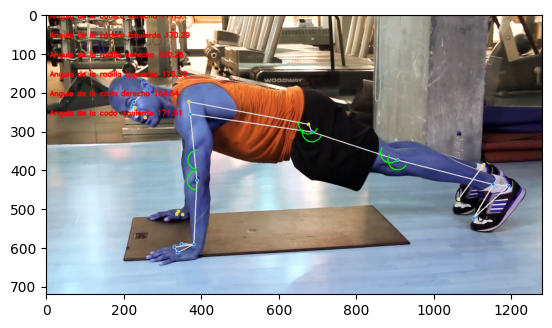

In [154]:
#########Draw arcs and get angles###########
x=0
y=1
good = (0,255,0)
bad = (0,0,255)
height, width,_ = images[0].shape

#Elbow angles
elbow_angles = [[],[]]
#Knee angles
knee_angles = [[],[]]
#Wrist angles
wrist_angles = [[],[]]
#Waist angles
waist_angles = [[],[]]

R=0
L=1
frame = 0
for image in images:
  #####Elbow
  A = [int(data['LEFT_SHOULDER'][frame, x] * width), int(data['LEFT_SHOULDER'][frame, y] * height)]
  B = [int(data['LEFT_ELBOW'][frame, x] * width), int(data['LEFT_ELBOW'][frame, y] * height)]
  C = [int(data['LEFT_WRIST'][frame, x] * width), int(data['LEFT_WRIST'][frame, y] * height)]
  angleL = central_angle(A,B,C)
  A = [int(data['RIGHT_SHOULDER'][frame, x] * width), int(data['RIGHT_SHOULDER'][frame, y] * height)]
  B = [int(data['RIGHT_ELBOW'][frame, x] * width), int(data['RIGHT_ELBOW'][frame, y] * height)]
  C = [int(data['RIGHT_WRIST'][frame, x] * width), int(data['RIGHT_WRIST'][frame, y] * height)]  
  angleR = central_angle(A,B,C)

  elbow_angles[L].append(angleL)  
  elbow_angles[R].append(angleR)  
  
  if angleL >= 50:
    state = good
  else:
    state = bad
  draw_arc(data['RIGHT_SHOULDER'][frame, x], data['RIGHT_ELBOW'][frame, x], data['RIGHT_SHOULDER'][frame, y], data['RIGHT_ELBOW'][frame, y], data['LEFT_SHOULDER'][frame, x], data['LEFT_ELBOW'][frame, x], data['LEFT_SHOULDER'][frame, y], data['LEFT_ELBOW'][frame, y], angleR, angleL, image, width, height, state)
  write_value('codo izquierdo', angleL, image, [10,260])
  write_value('codo derecho', angleR, image, [10,210])
  
  #####Knee
  A = [int(data['LEFT_HIP'][frame, x] * width), int(data['LEFT_HIP'][frame, y] * height)]
  B = [int(data['LEFT_KNEE'][frame, x] * width), int(data['LEFT_KNEE'][frame, y] * height)]
  C = [int(data['LEFT_ANKLE'][frame, x] * width), int(data['LEFT_ANKLE'][frame, y] * height)]
  angleL = central_angle(A,B,C)
  A = [int(data['RIGHT_HIP'][frame, x] * width), int(data['RIGHT_HIP'][frame, y] * height)]
  B = [int(data['RIGHT_KNEE'][frame, x] * width), int(data['RIGHT_KNEE'][frame, y] * height)]
  C = [int(data['RIGHT_ANKLE'][frame, x] * width), int(data['RIGHT_ANKLE'][frame, y] * height)]
  angleR = central_angle(A,B,C)  

  knee_angles[L].append(angleL)
  knee_angles[R].append(angleR)
  if angleL >= 150:
    state = good
  else:
    state = bad  
  draw_arc(data['RIGHT_HIP'][frame, x], data['RIGHT_KNEE'][frame, x], data['RIGHT_HIP'][frame, y], data['RIGHT_KNEE'][frame, y], data['LEFT_HIP'][frame, x], data['LEFT_KNEE'][frame, x], data['LEFT_HIP'][frame, y], data['LEFT_KNEE'][frame, y], angleR, angleL, image, width, height, state)
  write_value('rodilla izquierda', angleL, image, [10, 160])
  write_value('rodilla derecha', angleR, image, [10, 110])


  #####Hip
  A = [int(data['LEFT_SHOULDER'][frame, x] * width), int(data['LEFT_SHOULDER'][frame, y] * height)]
  B = [int(data['LEFT_HIP'][frame, x] * width), int(data['LEFT_HIP'][frame, y] * height)]
  C = [int(data['LEFT_KNEE'][frame, x] * width), int(data['LEFT_KNEE'][frame, y] * height)]
  angleL = central_angle(A,B,C)
  if slope_compare(A,B,C):
    angleL = abs(360-angleL)
  waist_angles[L].append(angleL)  
  A = [int(data['RIGHT_SHOULDER'][frame, x] * width), int(data['RIGHT_SHOULDER'][frame, y] * height)]
  B = [int(data['RIGHT_HIP'][frame, x] * width), int(data['RIGHT_HIP'][frame, y] * height)]
  C = [int(data['RIGHT_KNEE'][frame, x] * width), int(data['RIGHT_KNEE'][frame, y] * height)]
  angleR = central_angle(A,B,C)  
  if slope_compare(A,B,C):
    angleR = abs(360-angleR)
  waist_angles[R].append(angleR)


  if angleL >= 150 and angleL <= 180:
    state = good
  else:
    state = bad 

  draw_arc(data['RIGHT_SHOULDER'][frame, x], data['RIGHT_HIP'][frame, x], data['RIGHT_SHOULDER'][frame, y], data['RIGHT_HIP'][frame, y], data['LEFT_SHOULDER'][frame, x], data['LEFT_HIP'][frame, x], data['LEFT_SHOULDER'][frame, y], data['LEFT_HIP'][frame, y], angleR, angleL, image, width, height, state)
  write_value('cadera izquierda', angleL, image, [10, 60])
  write_value('cadera derecha', angleR, image, [10, 10])

  frame += 1

plt.imshow(image)

In [155]:

# Define the output video filename and properties
output_filename = 'grong.mp4'
fps = 30
frame_size = (width, height)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_filename, fourcc, fps, frame_size)

# Write each image to the video file
for frame in images:
  video_writer.write(frame)

# Release the video writer
video_writer.release()


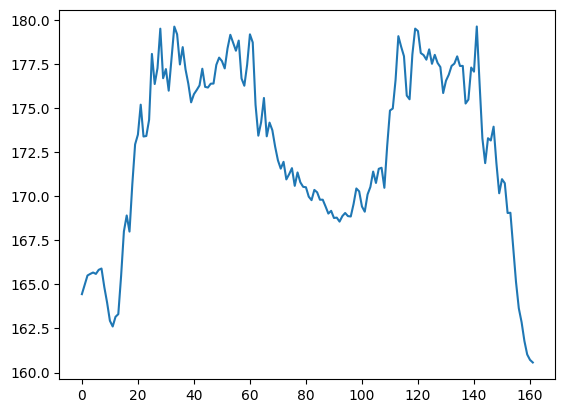

In [48]:
plt.plot(waist_angles)

KeyboardInterrupt: ignored

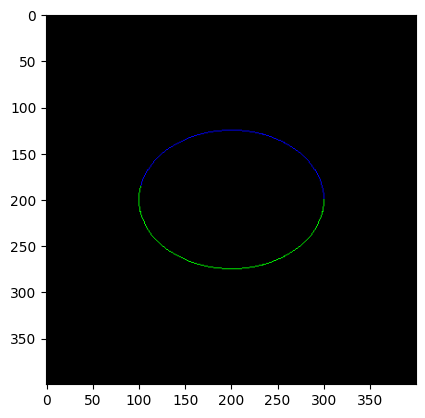

In [126]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

center = (200, 200) # x,y
axes = (100, 75) # first, second
angle = 0. # clockwise, first axis, starts horizontal
for i in range(360):
  image = np.zeros((400, 400, 3)) # creates a black image
  image = cv2.ellipse(image, center, axes, angle, 0., 360, (0,0,255))
  image = cv2.ellipse(image, center, axes, angle, 0., i, (0,255,0))
  plt.imshow(image)
  plt.show
  time.sleep(1)
